Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

current prompt: Red and white commuter train riding down tracks next to the highway. 


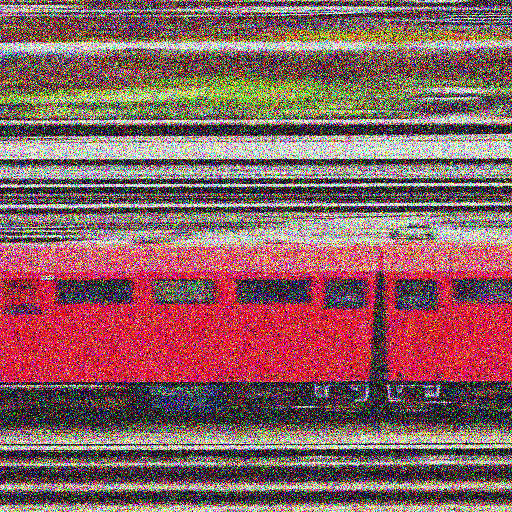

17
8
current prompt: Playing board games while the iron heats up in the bedroom.


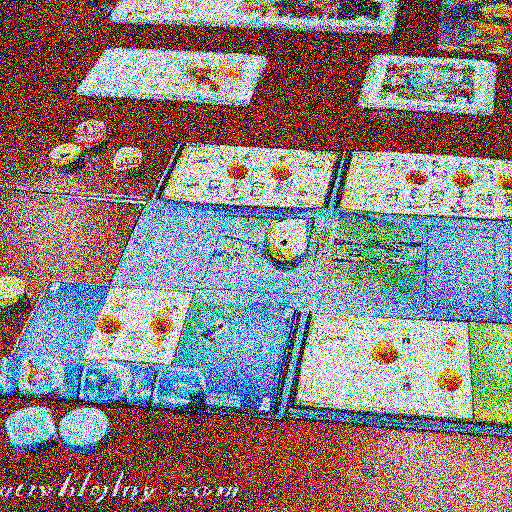

11
12
current prompt: A woman sitting in a room near some computers.


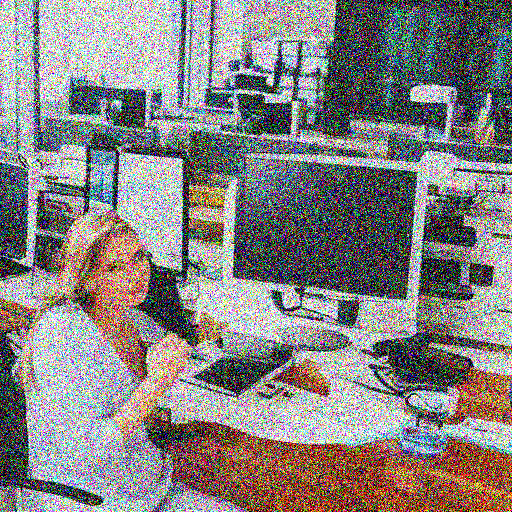

12
8
current prompt: A brown cat is sitting on a wood floor.


KeyboardInterrupt: 

In [2]:
import argparse
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt
from utils import *
import random
import numpy as np
import math
import os 
import scipy
import torch.nn as nn
from modified_stable_diffusion import ModifiedStableDiffusionPipeline
import PIL
from PIL import Image, ImageFilter,ImageEnhance
import commpy.utilities as util
import cv2
from bm3d import bm3d_rgb

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='diffusion watermark')
    parser.add_argument('--w_seed', default=0, type=int)
    # parser.add_argument('--dataset', default='Gustavosta/Stable-Diffusion-Prompts')
    parser.add_argument('--dataset', default='coco')
    # parser.add_argument('--dataset', default='stablediffusionDB')
    # parser.add_argument('--model_path', default='../stable-diffusion-2-1-base')
    parser.add_argument('--model_path', default='../stable-diffusion-v1-4')
    parser.add_argument('--image_length', default=512, type=int)
    parser.add_argument('--secret_length', default=48, type=int)
    parser.add_argument('--num_inference_steps', default=25, type=int)
    parser.add_argument('--guidancescale', default=5, type=float)
    parser.add_argument('--reverse_inference_steps', default=25, type=int)
    # parser.add_argument('--model', default='./encoder_decoder_pretrain/model48bit.pth', type=str)
    # parser.add_argument('--model', default='./model48bit_finetuned.pth', type=str)
    parser.add_argument('--model', default='./model48bit_finetuned_backup.pth', type=str)
    parser.add_argument('--birghtness', default=None, type=float,choices=[1,2,3,4,5])
    parser.add_argument('--noise', default=100, type=float,choices=[0.01,0.05])
    parser.add_argument('--contrast', default=None, type=float,choices=[1,2,3,4,5])
    parser.add_argument('--hue', default=None, type=float,choices=[0.25,2])
    parser.add_argument('--blur', default=None, type=int,choices=[1,3,5])
    parser.add_argument('--jpegcompression', default=None, type=int,choices=[40,50])
    parser.add_argument('--resize', default=None, type=float,choices=[0.4,0.8])
    parser.add_argument('--bm3d', default=None, type=float,choices=[10,20])
    
    parser.add_argument('--crop_scale', default=0.95, type=float)
    parser.add_argument('--crop_ratio', default=0.95, type=float)

    args =parser.parse_known_args()[0]
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    torch.set_printoptions(sci_mode=False,profile='full')
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    maxlength=150
    
# dataset
dataset, prompt_key = get_dataset(args)
dataset=promptdataset(dataset,prompt_key)

#model
scheduler = DPMSolverMultistepScheduler.from_pretrained(args.model_path, subfolder='scheduler')
pipe = ModifiedStableDiffusionPipeline.from_pretrained(
        args.model_path,
        scheduler=scheduler,
        torch_dtype=torch.float16,
        revision='fp16',
        )
pipe = pipe.to(device)

#diffusetrace
from encoder_decoder_pretrain.watermark_model import *
encoder=Watermark(secret_length=args.secret_length).to(device)
if args.model !=None:
    encoder.load_state_dict(torch.load(args.model))
encoder.eval()

#rsc codes
import commpy.channelcoding.convcode as cc
memory = np.array(2, ndmin=1)
g_matrix = np.array((0o5, 0o7), ndmin=2)
trellis = cc.Trellis(memory, g_matrix)

Metric,Loss,Error_correct=[],[],[]
for t in tqdm(range(6)):
    initial_latents=get_random_latents(pipe,args)
    init_latents=initial_latents.detach().clone()
    secret_ori=np.random.choice([0, 1], size=(args.secret_length//2))
    secret = cc.conv_encode(secret_ori,trellis,'cont')
    secret = torch.Tensor(secret).unsqueeze(-1).unsqueeze(-1).unsqueeze(0).to(device)
    secret = secret.expand(-1,-1,64,64)
    matrix1,mean,logvar=encoder(secret)
    mean=mean.reshape(-1,4,64,64)
    logvar=logvar.reshape(-1,4,64,64)
    eps = torch.randn_like(logvar)
    std = torch.exp(logvar / 2)
    matrix = eps * std + mean
    init_latents=matrix.half()

    prompt=dataset[random.randint(1, len(dataset))][0:maxlength]
    # prompt=dataset[t+100][0:maxlength]
    print(f"current prompt: {prompt}")
    img1= pipe(prompt=prompt,num_inference_steps=args.num_inference_steps,\
    latents=init_latents,guidance_scale=args.guidancescale).images[0]
    
    # img2= pipe(prompt=prompt,num_inference_steps=args.num_inference_steps,\
    # latents=initial_latents,guidance_scale=args.guidancescale).images[0]
    
    if args.birghtness != None:
                img1 = transforms.ColorJitter(brightness=args.birghtness)(img1)
    if args.noise != None:
                img1 = np.array(img1, dtype=np.uint8)
                g_noise = np.random.randn(*img1.shape).astype(np.float32) * args.noise
                noisy_array = np.clip(img1.astype(np.float32) + g_noise, 0, 255).astype(np.uint8)
                img1 = Image.fromarray(noisy_array)
                # g_noise = (np.random.normal(0, args.noise, np.array(img1).shape) * 255).astype(np.uint8)
                # img1 = Image.fromarray(np.clip(np.array(img1, dtype=np.int16) + g_noise, 0, 255).astype(np.uint8))
    if args.contrast != None:
                enhancer = ImageEnhance.Contrast(img1)
                factor = args.contrast
                img1= enhancer.enhance(factor)
    if args.hue != None:
                enhancer = ImageEnhance.Color(img1)
                factor = args.hue
                img1 = enhancer.enhance(factor)
    if args.jpegcompression != None:
                img1=compress_jpeg_to_pil(img1, args.jpegcompression)
    if args.blur != None:
                img1=Image.fromarray(cv2.GaussianBlur(np.array(img1),(args.blur,args.blur), 1))
    if args.resize != None:
                img1 = img1.resize((int(args.image_length*args.resize), int(args.image_length*args.resize)), PIL.Image.BICUBIC)
    if args.bm3d != None:
                rgb_array = np.array(img1)
                denoised_red = bm3d_rgb(rgb_array,sigma_psd=args.bm3d)
                img1 = Image.fromarray(denoised_red.astype(np.uint8))
                
    # if args.crop_scale is not None and args.crop_ratio is not None:
    #     set_random_seed(0)
    #     img1 = transforms.RandomResizedCrop(img1.size, scale=(args.crop_scale, args.crop_scale), ratio=(args.crop_ratio, args.crop_ratio))(img1)
    

    # from PIL import Image, ImageFilter,ImageDraw
    # import os
    # from torchvision import transforms
    # import numpy as np
    # import random 
    # from PIL import Image, ImageFilter,ImageDraw
    # import os
    # from torchvision import transforms
    # import numpy as np
    # import random 
    # p_rand=0.9
    # width, height = img1.size
    # black_image = Image.new('RGB', (width, height), color='black')
    # crop_width = int(width * p_rand)
    # crop_height = int(height * p_rand)
    # crop_width = max(1, crop_width)
    # crop_height = max(1, crop_height)
    # left = random.randint(0, width - crop_width)
    # top = random.randint(0, height - crop_height)
    # right = left + crop_width
    # bottom = top + crop_height
    # black_image.paste(img1, (0, 0))
    # draw = ImageDraw.Draw(black_image)
    # draw.rectangle([left, top, right, bottom], fill='black')
    # img1=black_image
    
    # import random
    # p_area = 0.7
    # width, height = img1.size
    # new_width = width * p_area
    # new_height = height * p_area
    # max_left = width - new_width
    # max_top = height - new_height
    # left = random.randint(0, int(max_left))
    # top = random.randint(0, int(max_top))
    # right = left + new_width
    # bottom = top + new_height
    # black_background = Image.new('RGB', (width, height), (0, 0, 0))
    # cropped_image = img1.crop((left, top, right, bottom))
    # black_background.paste(cropped_image, (int(left), int(top)))
    # img1=black_background
    
    # crop_ratio=0.4
    # img1 = transforms.RandomResizedCrop(size=img1.size, scale=(crop_ratio, crop_ratio), ratio=(1,1))(img1)

    # rotation=90
    # img1 = transforms.RandomRotation((rotation, rotation))(img1)
    img1.show()
    
    
    # import torchvision.transforms.functional as TF
    # tensor1 = TF.to_tensor(img1)
    # tensor2 = TF.to_tensor(img2)
    # concatenated_tensor = torch.cat((tensor1, tensor2), dim=2)
    # concatenated_image = TF.to_pil_image(concatenated_tensor)
    # concatenated_image.show()
    
    reverse_latents=reverse(img1,pipe,args).float()
    reverse_latents = reverse_latents.view(1, -1)
    x = encoder.decoder_projection(reverse_latents)
    x = torch.reshape(x, (-1, *encoder.decoder_input_chw))

    average_tensor1 = torch.mean(secret, dim=(-2, -1))
    average_tensor2 = torch.round(torch.mean(encoder.decoder(x), dim=(-2, -1)))
    average_tensor3 = torch.mean(encoder.decoder(x), dim=(-2, -1))
    matrix_ori=torch.mean(matrix1, dim=(-2, -1))

    biterror=torch.sum(abs(average_tensor1-average_tensor2))
    mse_loss = torch.nn.MSELoss()
    loss = mse_loss(average_tensor3, average_tensor1)
    
    decoded_bits = cc.viterbi_decode(np.array(average_tensor2[0].detach().cpu()).astype(float), trellis, 5)
    num_bit_errors = util.hamming_dist(secret_ori, decoded_bits[:args.secret_length//2])
    Error_correct.append(num_bit_errors)
    
    # print(int(biterror.detach().cpu().numpy()))
    print(int(biterror.detach().cpu().numpy()))
    print(num_bit_errors)
    Metric.append(biterror)
    Loss.append(loss)
    
biterror=torch.mean(torch.stack(Metric))
biterrper=biterror/args.secret_length
metric=torch.mean(torch.stack(Loss))
correctbit_err=np.mean(Error_correct)
# detection_rate = 1 - sum(1 for i in Metric if i > 14) / len(Metric)
detection_rate = 1 - sum(1 for i in Metric if i > 8) / len(Metric)
print(f'loss bits',f'{biterror.cpu().detach().numpy()}')
print(f'bit acc percentage {(1-biterrper)*100:.2f}%')
print(f'loss',f'{metric.cpu().detach()}')
print(f'bit error average',f'{biterror.detach().cpu().numpy():.2f}')
print(f'bit error correct average',f'{correctbit_err:.2f}')
print(f'bit acc correct percentage',f'{(1-(correctbit_err/(args.secret_length//2)))*100:.2f}%')
print(f'detection rate (without correction): {detection_rate:.2f}')

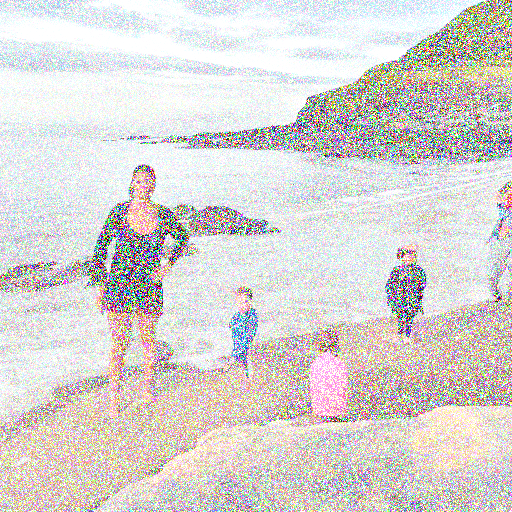

In [ ]:
img1.show()